# Tanner Murphey (cmurphey)
# Final Project: H-R Diagram fitting using GAIA data and Markov-Chain Monte Carlo

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as T
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


I'm going to trim down noisy measurements because, especially at very low parallax, that can drastically alter the estimated distance which messes up the apparent-to-absolute magnitude conversion. There isn't any light extinction data so I just have to ignore it/hope it isn't too significant. To make up for the trimming down of data, I'm combining the data from 4 randomly selected data sets. Any more and the cell right below starts taking a few minutes to run.

In [6]:
cutoff = 50 # parallax to error threshold
data1 = pd.read_csv("GaiaSource_786097-786431.csv.gz")
data1 = data1[data1['parallax_over_error'] > cutoff]
data2 = pd.read_csv("GaiaSource_688632-688658.csv.gz")
data2 = data2[data2['parallax_over_error'] > cutoff]
data3 = pd.read_csv("GaiaSource_020092-020493.csv.gz")
data3 = data3[data3['parallax_over_error'] > cutoff]
data4 = pd.read_csv("GaiaSource_023451-023649.csv.gz")
data4 = data3[data3['parallax_over_error'] > cutoff]
data = ((data1.append(data2)).append(data3)).append(data4)
del(data1, data2, data3, data4) # to save memory, these are large files

In [14]:
distance = 1 / (data['parallax']*1000) # parsec from milliarcseconds

dist_modulus = -2.5*(distance/10) # distance modulus

abs_g_mag = np.array(data['phot_g_mean_mag'] - dist_modulus)


In [74]:
print((len(data.columns)))

99


I guess, just out of curiosity, lest see where these stars are with respect to the sun. I'll also add the galactic center just for an extra reference so we have a better idea of the scale

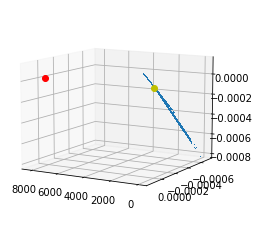

In [15]:
x = distance * np.cos((data['b'])*np.pi/180)*np.cos(data['b']*np.pi/180)
y = distance * np.cos(data['b']*np.pi/180)*np.sin(data['b']*np.pi/180)
z = distance * np.sin(data['b']*np.pi/180)

ax = plt.axes(projection='3d')
ax.plot(x, y, z, ',')
ax.plot(8200, 0, 0, 'ro') # Galactic center
ax.plot(0, 0, 0, 'yo') # sun
ax.view_init(10, 120)

Now, lets make an H-R diagram:

In [16]:
distance = 1000/data['parallax'] # parsec
dist_modulus = -2.5*np.log10(distance / 10) #distance modulus magnitude loss

g_abs_mag = data['phot_g_mean_mag'] + dist_modulus

Text(0.5, 1.0, 'H-R Diagram of 4 GAIA Data Collections')

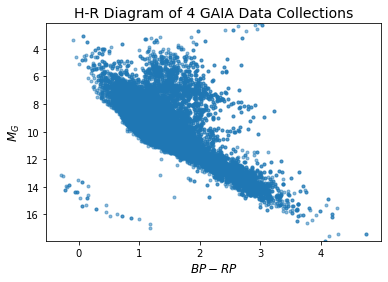

In [17]:
plt.plot(data['bp_rp'], g_abs_mag, '.', alpha=0.5)
plt.ylim(max(g_abs_mag), min(g_abs_mag)) # because magnitudes
plt.ylabel(r"$M_G$", size=12)
plt.xlabel(r"$BP - RP$", size=12)
plt.title("H-R Diagram of 4 GAIA Data Collections", size=14)

As I said above, we are ignoring magnitude losses due to dust. I have a strong feeling that that is a significant contributor to the thickness of the main sequence line but we do not have light extinction data so we can't account for it. This also is only the G-band absolute magnitude which, [according to GAIA's website](https://www.cosmos.esa.int/web/gaia/iow_20180316) covers most of the visible band. This obviously isn't the bolometric magnitude but that isn't available in the dataset and this is the closest we have since GAIA's G-band covers essentially all of it's other bands.

That being said, it looks like a pretty solid H-R diagram. The main sequence is very visible and there are several stars in the giants areas and some white dwarfs. 

I guess this would be a good time to see if we can sort out if these stars are on the main sequence or not and then see if we can fit a line. We'll do that with PyMC3

In [71]:
with pm.Model() as Model:
    m = pm.Normal("m", mu=5, sigma=2)
    b = pm.Normal("b", mu=4, sigma=2)
    
    mu_b = pm.Normal('mu_b', mu=8, sigma=1)
    sigma_b = pm.Lognormal('sigma_b', mu=log(7), sigma=log(2))

    P_giant = pm.Beta("P_giant", alpha = 1, beta=11) # probability that star is not MS
    ys_true = pm.Deterministic('ys_true', m*data['bp_rp'] + b)
    ys_obs = np.array(g_abs_mag)

    logp_good = T.log1p(-P_giant) + pm.Normal.dist(mu=ys_true, sigma=data['phot_g_mean_flux_error']).logp(ys_obs)
    logp_bad = T.log(P_giant) + pm.Normal.dist(mu=mu_b*ones_like(ys_obs), sigma=sigma_b).logp(ys_obs)

    log_odds = pm.Deterministic('log_odds', logp_good - logp_bad)
    _ = pm.Potential('likelihood', T.sum(pm.logaddexp(logp_good, logp_bad)))

In [72]:
Model.check_test_point()

m                   -1.61
b                   -1.61
mu_b                -0.92
sigma_b_log__       -0.55
P_giant_logodds__   -1.04
Name: Log-probability of test_point, dtype: float64

In [73]:
with Model:
    mix_trace = pm.sample(draws=1000, tune=1000, chains=1)

/tmp/ipykernel_230022/3773362446.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  mix_trace = pm.sample(draws=1000, tune=1000, chains=1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [P_giant, sigma_b, mu_b, b, m]


SamplingError: Bad initial energy

In [ ]:
with Model:
    pm.plot_trace(mix)